<a href="https://colab.research.google.com/github/17026212/AIsub/blob/main/AISub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dataset collation**

This week I began collating my dataset. I've found images of white people and people of colour. (i.e. White, Black, Brown, Asian)
To automate this task I used a Google Chrome Web Extension called Image Downloader Continued and Google Image Search to download images for each Racial group. I then went through each subfolder and removed any images, which had any of these atributes.

*   Image being too small
*   Multiple people in the image
*   Clothing covering too much skin/face
*   Poor lighting
*   Person in the photo is too far away
*   Any image containing text/watermarks.









#Dataset split

I then divided each of my datasets into three sets for training, validation and testing. A common split is 70-15-15. So training (70%), validation (15%) and testing (15%). Inside my dataset folder I have three folders (train, val and test) and then inside of these are the four folders one for each class. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


I have uploaded my dataset to Google Drive in a zip folder but before that I must connect this Colab to my Google Drive.

In [ ]:
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

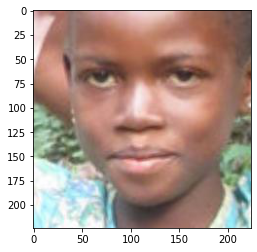

In [ ]:
image = mpimg.imread('/content/skin-colour-dataset/test/Black/3.jpg')
plt.imshow(image)
plt.show()

#MLP

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'skin-colour-dataset'

# define batch size
batch_size = 7

# # define transforms (grayscale)
# transform_gs = transforms.Compose([transforms.Grayscale(), # convert colour images to greyscale
#                                 transforms.Resize(28), # resize to 28x?
#                                 transforms.CenterCrop(28), # take a square (28x28) crop from the centre
#                                 transforms.ToTensor(), # convert data to torch.FloatTensor
#                                 transforms.Normalize(0.5, 0.5)]) # normalise with mean 0.5 and standard deviation 0.5

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(28), # resize to 28x?
                                transforms.CenterCrop(28), # take a square (28x28) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 

In [ ]:
# if using greyscale images, image size 28x28x1 = 784
# if using colour images, image size 28x28x3 = 2352
input_size = 2352
                                                                   
from torch import nn, optim
import torch.nn.functional as F

# define the NN architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # number of hidden nodes in each layer
        hidden_1 = 1028
        hidden_2 = 512
        hidden_3 = 256
        numberOfClasses = 7
        # linear layers
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 
        # Dropout module with 0.2 drop probability - to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(-1, input_size)
        # add hidden layers, with relu activation function, and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # add output layer with logSoftmax
        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

# initialise the NN
model = Classifier()
print(model)

In [ ]:
# specify loss function (negative log likelihood loss)
criterion = nn.NLLLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
# number of epochs to train the model
n_epochs = 30

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') # save in google drive
        valid_loss_min = valid_loss

In [ ]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('MLP_model.pt'))

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.7f}\n'.format(test_loss))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %7s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %7s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

# 0 is good, 1 is poor

#CNN

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'skin-colour-dataset'

# define batch size
batch_size = 12

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(32), # resize to 32x?
                                transforms.CenterCrop(32), # take a square (32x32) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 5 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(12,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 


In [ ]:
#########################################################################
# this code is different to last week - here we define a CNN architecture
#########################################################################

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 5x5x64)
        self.fc1 = nn.Linear(64 * 4 *4, 700)
        # fully connected layer 2 (input 700, output 7 - four classes)
        self.fc2 = nn.Linear(700, 7) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)

#########################################################################
#########################################################################

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/AI/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.954579 	Validation Loss: 1.945890
Validation loss decreased (inf --> 1.945890).  Saving model ...
Epoch: 2 	Training Loss: 1.947907 	Validation Loss: 1.946035
Epoch: 3 	Training Loss: 1.948550 	Validation Loss: 1.945900
Epoch: 4 	Training Loss: 1.947293 	Validation Loss: 1.941382
Validation loss decreased (1.945890 --> 1.941382).  Saving model ...
Epoch: 5 	Training Loss: 1.956661 	Validation Loss: 1.945823
Epoch: 6 	Training Loss: 1.935133 	Validation Loss: 1.943339
Epoch: 7 	Training Loss: 1.939955 	Validation Loss: 1.939170
Validation loss decreased (1.941382 --> 1.939170).  Saving model ...
Epoch: 8 	Training Loss: 1.913124 	Validation Loss: 1.899807
Validation loss decreased (1.939170 --> 1.899807).  Saving model ...
Epoch: 9 	Training Loss: 1.863892 	Validation Loss: 1.890800
Validation loss decreased (1.899807 --> 1.890800).  Saving model ...
Epoch: 10 	Training Loss: 1.874101 	Validation Loss: 1.941409
Epoch: 11 	Training Loss: 1.791817 	Validation Lo

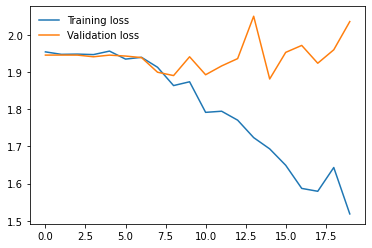

In [ ]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [ ]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.826757

Test Accuracy of     0: 13% ( 2/15)
Test Accuracy of     1: 40% ( 6/15)
Test Accuracy of     2: 33% ( 5/15)
Test Accuracy of     3: 26% ( 4/15)
Test Accuracy of     4: 33% ( 5/15)
Test Accuracy of     5: 26% ( 4/15)
Test Accuracy of     6: 26% ( 4/15)

Test Accuracy (Overall): 28% (30/105)


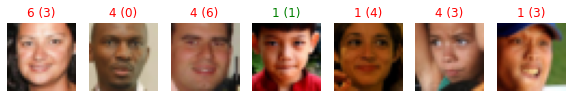

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 


#AI4

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'skin-colour-dataset'

# define batch size
batch_size = 12

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236), # resize to 236x?
                                transforms.RandomRotation(5), # random rotation
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

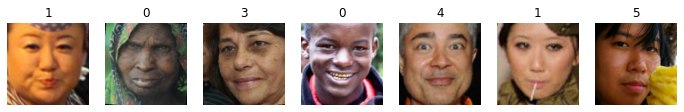

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(12,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Lion's mane Jellyfish, 1 is Moon Jellyfish, 2 is Pacific Sea Nettle, 3 is White spotted Jellyfish

In [ ]:
#########################################################################
# use a ResNet18 network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)

# # if we use the following code the pre-trained weights are frozen and we only update the final layer
# for param in model.parameters():
#     param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 7)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

# #########################################################################
# #########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimiser (Adam optimiser) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.073336 	Validation Loss: 2.399876
Validation loss decreased (inf --> 2.399876).  Saving model ...
Epoch: 2 	Training Loss: 1.518364 	Validation Loss: 1.754842
Validation loss decreased (2.399876 --> 1.754842).  Saving model ...
Epoch: 3 	Training Loss: 1.380501 	Validation Loss: 2.337033
Epoch: 4 	Training Loss: 1.268252 	Validation Loss: 2.127007
Epoch: 5 	Training Loss: 1.130594 	Validation Loss: 1.912942
Epoch: 6 	Training Loss: 1.128336 	Validation Loss: 1.905536
Epoch: 7 	Training Loss: 0.988953 	Validation Loss: 2.321190
Epoch: 8 	Training Loss: 0.900617 	Validation Loss: 1.849221
Epoch: 9 	Training Loss: 0.803106 	Validation Loss: 2.047640
Epoch: 10 	Training Loss: 0.728377 	Validation Loss: 2.544060
Epoch: 11 	Training Loss: 0.775268 	Validation Loss: 2.763810
Epoch: 12 	Training Loss: 0.650978 	Validation Loss: 2.145536
Epoch: 13 	Training Loss: 0.591243 	Validation Loss: 2.120784
Epoch: 14 	Training Loss: 0.478941 	Validation Loss: 2.234345
Epoch: 1

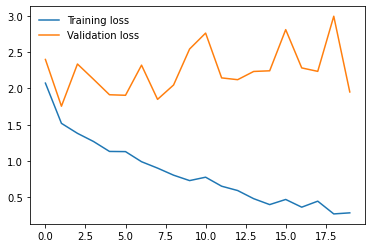

In [ ]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [ ]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.859221

Test Accuracy of     0: 60% ( 9/15)
Test Accuracy of     1: 46% ( 7/15)
Test Accuracy of     2: 13% ( 2/15)
Test Accuracy of     3: 13% ( 2/15)
Test Accuracy of     4: 40% ( 6/15)
Test Accuracy of     5: 26% ( 4/15)
Test Accuracy of     6: 60% ( 9/15)

Test Accuracy (Overall): 37% (39/105)


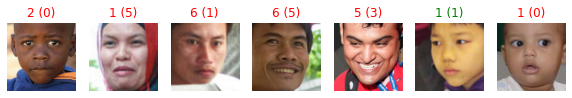

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,7), ncols=7)
for ii in range(7):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Lion's mane Jellyfish, 1 is Moon Jellyfish, 2 is Pacific Sea Nettle, 3 is White spotted Jellyfish

#AI5

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'skin-colour-dataset'

# define batch size
batch_size = 100

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

In [ ]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 7)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
race_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
race_feats = np.squeeze(race_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(race_feats.shape)
print(labels)

(100, 512)
(100, 512)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


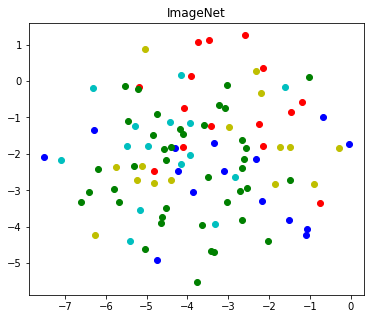

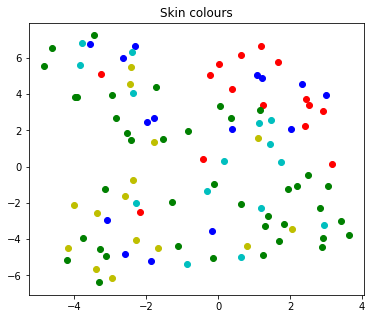

In [ ]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
race_X_2d = tsne.fit_transform(race_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Lion's mane Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Moon Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Pacific Sea Nettle
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is White spotted Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # 3 is White spotted Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')
  if labels[i] == 5:
    # 3 is White spotted Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 6:
    # 3 is White spotted Jellyfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
plt.title('ImageNet')
# plt.show()

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(race_X_2d.shape[0]):
  if labels[i] == 0:
    # Black
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # East asian
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # Indian
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # Latino - Hispanic
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='c')
  if labels[i] == 4:
    # Middle Eastern
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='y')
  if labels[i] == 5:
    # South East asian
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='g')
  if labels[i] == 6:
    # White
    plt.scatter(race_X_2d[i,0], race_X_2d[i, 1], c='g')
plt.title('Skin colours')
# plt.show()
plt.show()

#CAM


In [ ]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Unpacking objects: 100% (47/47), done.


In [ ]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [ ]:
import cam

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/AI/skin-colour-dataset.zip' > /dev/null

In [ ]:


import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image




from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

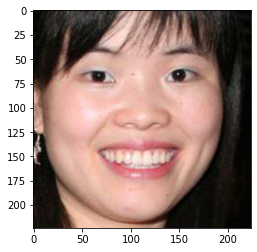

In [ ]:
# from ImageNet
#image = Image.open('./sample/tigercat.jpg')
#image = Image.open('./sample/dogsled.jpg')
image = Image.open('./skin-colour-dataset/test/East-Asian/100.jpg')
imshow(image)

In [ ]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [ ]:
#model = models.resnet18(pretrained=True)
#model.eval()
# print(model)
# if using greyscale images, image size 28x28x1 = 784
# if using colour images, image size 28x28x3 = 2352
input_size = 2352
                                                                   
from torch import nn, optim
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 5x5x64)
        self.fc1 = nn.Linear(64 * 4 *4, 700)
        # fully connected layer 2 (input 700, output 7 - four classes)
        self.fc2 = nn.Linear(700, 7) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
# the target layer you want to visualize
target_layer = model.conv2
# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model = GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [ ]:
cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


ValueError: ignored

In [ ]:
print(idx2label[idx])

seat belt, seatbelt


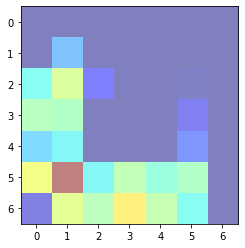

In [ ]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [ ]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [ ]:
heatmap = visualize(img, cam)

In [ ]:
# save image
#save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
#save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
#save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

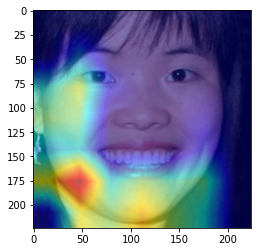

In [ ]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)